# Robust detrending, rereferencing, outlier detection, and inpainting, for-multichannel-data

Implementation of [1] in Python and experiments on real time series.  
Esteban Christiann (ENS Paris-Saclay) and Alexi Canesse (ENS de Lyon)

### Libraries Importation

In [1]:
import numpy as np
import utils
from scipy.signal import butter, lfilter
from meegkit.utils.sig import stmcb # Steiglitz-McBride iteration method for ringing removal

### Data Generation

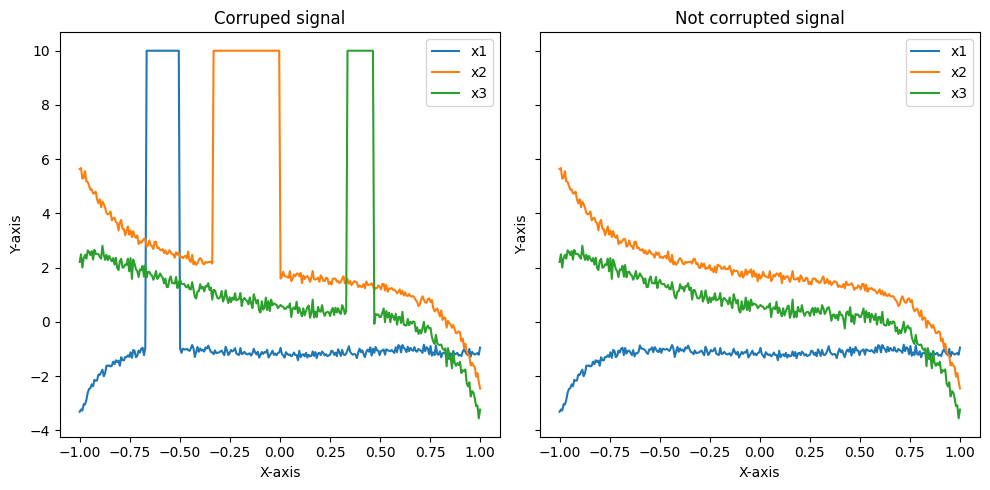

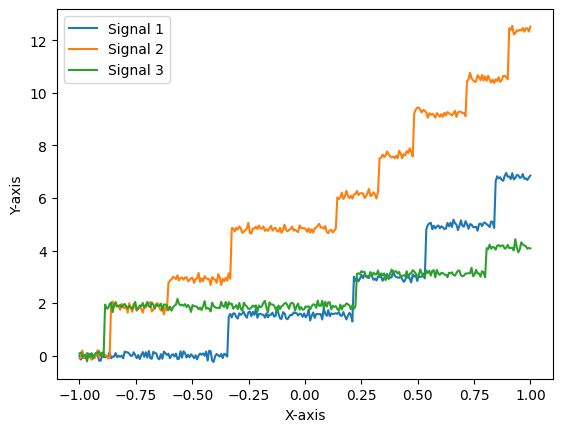

In [2]:
num_points = 300
t, x1, _ = utils.generate_noisy_polynomial(degree=10, noise_level=0.1, num_points=num_points)
_, x2, _ = utils.generate_noisy_polynomial(degree=10, noise_level=0.1, num_points=num_points)
x3 = x1 + x2 + np.random.normal(scale=0.1, size=[num_points])
x = np.stack([x1, x2, x3], axis=1)
x_not_corrupted = x.copy()

w = np.ones([num_points, 3], dtype=bool)
w[50:75, 0] = False
w[100:150, 1] = False
w[200:220, 2] = False

x[~w] = 10

utils.plot_signals_side_by_side(t, x.T, x_not_corrupted.T, y_names1=["x1", "x2", "x3"], y_names2=["x1", "x2", "x3"], title1="Corruped signal", title2="Not corrupted signal")

# Data with steps 
sigma = 1e-1
x_step = np.random.randn(3, num_points) * sigma
# Add steps
for signal in x_step:
    step_locations = utils.generate_random_numbers(np.random.randint(3, 10), 10, num_points - 9, 15)
    for step_location in step_locations:
        signal[step_location:] += 1. + np.random.random()
utils.plot_signals(t, x_step, title="")

## 1. Robust detrending

In [3]:
def robust_detrend(x, order, w=None, basis='polynomials', thresh=0.5, niter=4):
     """
     Robustly removes trend from data.

     Parameters:
     - x: raw data
     - order: order of polynomial or number of sin/cosine pairs
     - w: weights
     - basis: 'polynomials' [default] or 'sinusoids', or user-provided matrix
     - thresh: threshold for outliers [default: .5 sd]
     - niter: number of iterations [default: 4]

     Returns:
     - original - trend: detrended data
     - trend: trend
     - w: updated weights
     - r: basis matrix used
     """
     # Generate basis matrix
     if isinstance(basis, np.ndarray):
          r = basis
     else:
          lin = np.linspace(-1, 1, x.shape[0])
          if basis == 'polynomials':
               r = np.column_stack([lin ** k for k in range(0, order + 1)])
          elif basis == 'sinusoids':
               r = np.column_stack([np.sin(2 * np.pi * k * lin / 2) for k in range(0, order + 1)] +
                                   [np.cos(2 * np.pi * k * lin / 2) for k in range(0, order + 1)])
          else:
               raise ValueError("Invalid basis type")

     # Initialize weights if not provided
     if w is None:
          w = np.ones_like(x, dtype=bool)[:, np.newaxis]
     
     # If the data is multichannel, the algorithm is applied to each channel independently 
     trend = x.copy()
     original = x.copy()
     if len(trend.shape) == 1:
          trend = trend[:, np.newaxis]
          original = original[:, np.newaxis]
     for i in range(niter):
          # If the data is multichannel, the algorithm is applied to each channel independently 
          for dim in range(trend.shape[1]):
               # Fit to basis
               coefficients, residuals, _, _ = np.linalg.lstsq(r[w[:, dim],:], original[w[:, dim], dim], rcond=None)
               trend[:,dim] = r @ coefficients
               # Update weights
               d = np.abs(trend[:,dim] - original[:,dim])
               w[:,dim] = [0 if dt > thresh * np.std(d) else 1 for dt in d]


     return original - trend, trend, w, r

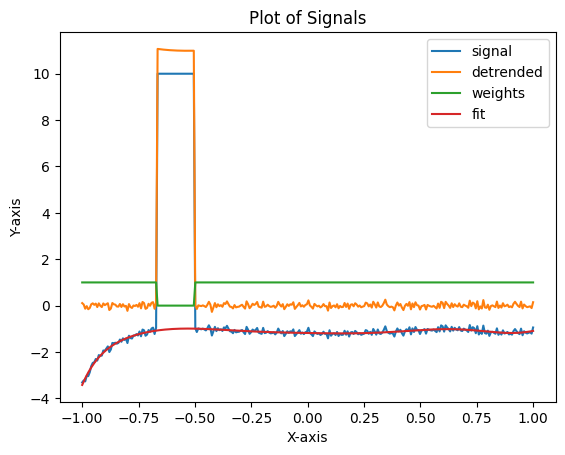

In [4]:
detrended_x1, trend_x1, weights_x1, _ = robust_detrend(x[:, 0], 10, niter=5, thresh=1)
utils.plot_signals(t, [x[:, 0], detrended_x1[:, 0], weights_x1, trend_x1], y_names=["signal", "detrended", "weights", "fit"])

## 2. Inpainting

In [5]:
def inpaint(x, w, keep_valid=True):
    """
    Reconstruct data if corrupted samples are known

    Parameters:
    - x: Nchannels x Nsamples raw data
    - w: Nchannels x Nsamples bool matrix indicating corruptions
    - keep_valid: set to true to reconstruct only corrupted samples

    Returns:
    - new_x: reconstructed data
    """
    if w is None:
        w = np.ones_like(x, dtype=bool)

    N = x.shape[1] # Number of channels
    new_x = x.copy()

    for n in range(N):
        w_other = w.copy()
        w_other[:, n] = False

        # Partition the time axis using the state of other channels
        pattern, partition = np.unique(w_other, axis=0, return_inverse=True)
        K = pattern.shape[0]

        for k in range(K):
            T_k = partition == k
            Tprime_k = np.logical_and(w[:, n], T_k) # Timestamps we use to estimate the projection
            
            Tinpaint = np.logical_and(~w[:, n], T_k) # Timestamps to reconstruct
            if not keep_valid:
                Tinpaint = T_k

            if Tinpaint.any():
                xn = x[:, n]
                xother = x[:, pattern[k]]
                xother = np.concatenate([xother, np.ones_like(xn)[:, None]], axis=1)

                # Estimate the coefficients and reconstuct the data
                coefs = np.linalg.lstsq(xother[Tprime_k], xn[Tprime_k], rcond=None)[0]
                new_x[Tinpaint, n] = xother[Tinpaint] @ coefs

    return new_x

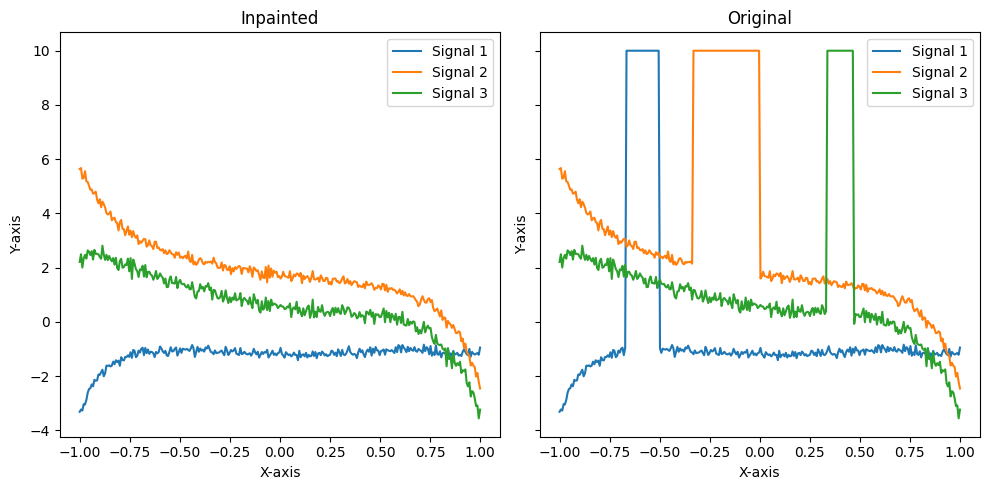

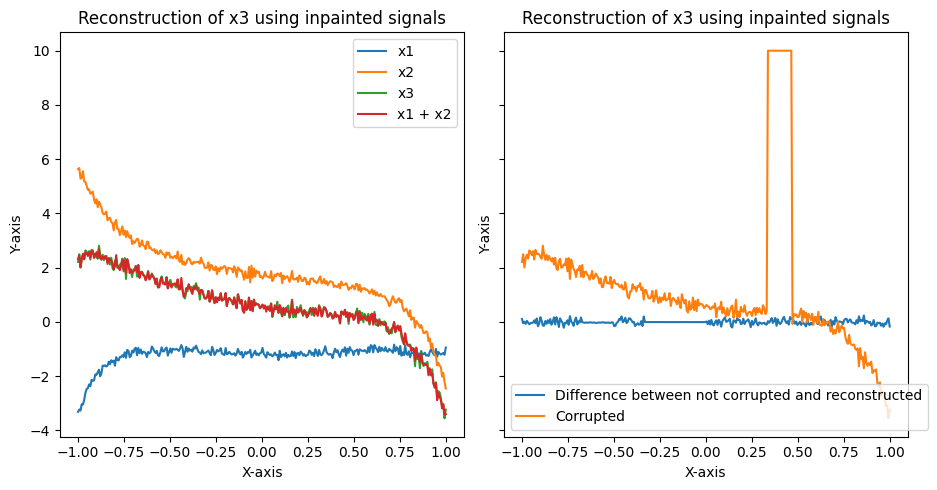

In [10]:
x_inpaint = inpaint(x, w)

utils.plot_signals_side_by_side(t, x_inpaint.T, x.T, title1="Inpainted", title2="Original")

to_plot = np.concatenate([x_inpaint, x_inpaint[:, [0]] + x_inpaint[:, [1]]], axis=1)
utils.plot_signals_side_by_side(t, to_plot.T, [x_inpaint[:, 0] + x_inpaint[:, 1] - x_not_corrupted[:,2], x[:,2]], y_names1=["x1", "x2", "x3", "x1 + x2"], y_names2=["Difference between not corrupted and reconstructed", "Corrupted"], title1="Reconstruction of x3 using inpainted signals", title2="Reconstruction of x3 using inpainted signals")

## 3. Outlier Detection

In [ ]:
def outlier_detection(x, thres=2., maxiter=10):
    """
    Flag outliers using the inpaint algorithm

    Parameters:
    - x: Nchannels x Nsamples raw data
    - thres: threshold for outlier detection (default: 2 stddev)
    - maxiter: maximum number of iterations

    Returns:
    - w: Nchannels x Nsamples bool matrix where False indicates an outlier
    """
    w = np.ones_like(x, dtype=bool) # Initially assume there are no outliers

    for _ in range(maxiter):
        # Try to reconstruct the data using the inpainting algorithm
        xbar = inpaint(x, w, keep_valid=False)

        # Flag high reconstruction errors as outliers
        d = np.abs(x - xbar)
        new_w = ~(d > thres * d.std())
        
        # Early stopping if the algorithm has converged
        if (w == new_w).all():
            return w
        w = new_w
    
    return w

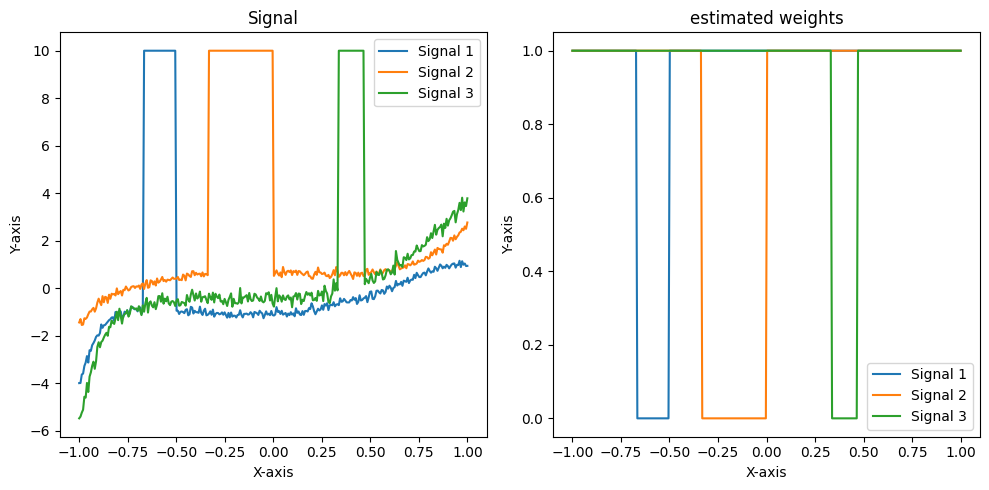

In [ ]:
estimated_w = outlier_detection(x, maxiter=20)
utils.plot_signals_side_by_side(t, x.T, estimated_w.T, title1="Signal", title2="estimated weights")

## 4. Robust Rereferencing

In [ ]:
def robust_rereferencing(x):
    """
    Perform robust referencing on the input signal.

    Parameters:
    - x (numpy.ndarray): Input signal.

    Returns:
    - numpy.ndarray: Robustly referenced signal.
    """
    w = outlier_detection(x)
    robust_mean = np.mean(x, where=w)
    return x - robust_mean

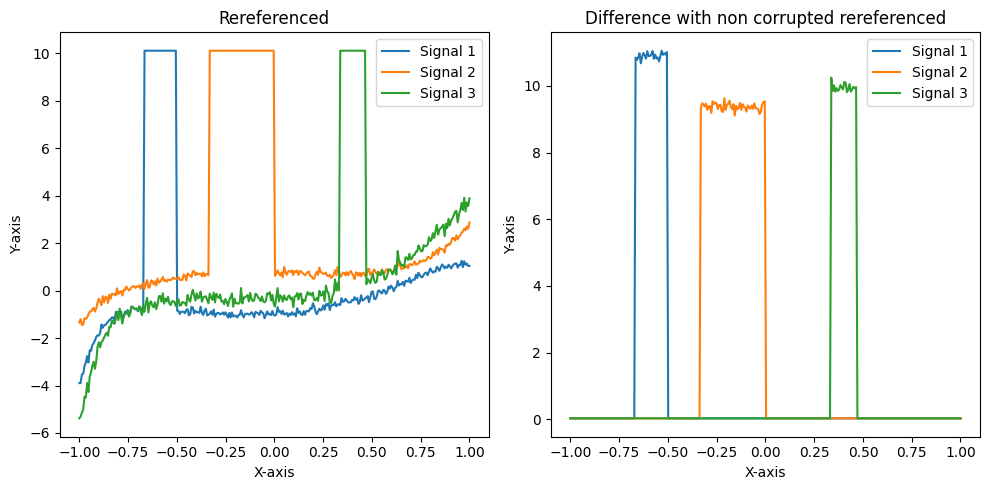

In [ ]:
rereferenced_x = robust_rereferencing(x)
utils.plot_signals_side_by_side(t, rereferenced_x.T, rereferenced_x.T - (x_not_corrupted.T - np.mean(x_not_corrupted)), title1="Rereferenced", title2="Difference with non corrupted rereferenced")

## 5. Step Removal

In [ ]:
def find_steps(x, thresh, guard, depth):
    """
    Find step glitch

    Parameters:
    - x (numpy.ndarray): Data to clean.
    - thresh (float): Threshold
    - guard (int): Minimum duration of stable interval in samples .
    - depth (int): Recursion depth, determines the number of steps.

    Returns:
    - stepList (list): Indices of steps.
    """
    if depth == 0 or len(x) < 2 * guard:
        return []

    T = x.shape[0] # x is a single channel here
    M = np.array([np.array([np.mean(x[t_low:t_high + 1]) for t_high in range(t_low, T)]) for t_low in range(T)])
    V = np.array([np.array([np.sum(np.square(x[t_low:t_high + 1] - M[t_low][t_high - t_low])) for t_high in range(t_low, T)]) for t_low in range(T)])

    t0 = np.nanargmin([V[0][t] + V[t][-1] for t in range(guard, T - guard)])
    steps = [guard + t0]

    # Check if the step is relevent 
    if (V[0][t0] + V[t0][-1])/V[0][-1] > thresh:
        return []

    if depth and steps:
        steps_left = find_steps(x[:steps[0]], thresh=thresh, guard=guard, depth=depth-1)
        # Add an offset because x[steps[0] + 1] becomes index 0
        steps_right = steps[0] + 1 + find_steps(x[steps[0]+1:], thresh=thresh, guard=guard, depth=depth-1)
        steps = np.concatenate((steps_left, steps, steps_right))

    return steps.astype(int)

def step_removal(x, thresh=.7, guard=5, depth=5):
    """
    Remove step glitch
    
    Parameters:
    - x (numpy.ndarray): Data to clean (time * channels).
    - thresh (float): Threshold (default: 0.7).
    - guard (int): Minimum duration of stable interval in samples (default: 5).
    - depth (int): Recursion depth (default: 5), determines the number of steps.

    Returns:
    - y (numpy.ndarray): Step-removed data.
    - stepList (list): Indices of steps.
    """

    y = x.copy()

    all_stepList = []
    for chan in range(x.shape[1]):
        # Find step indices
        stepList = find_steps(x[:, chan], thresh=thresh, guard=guard, depth=depth)

        if len(stepList):
            stepList = [0] + list(stepList) + [x.shape[0]]
            for split in range(1, len(stepList) - 1):
                y1 = y[stepList[split - 1] + 1 : stepList[split] - 1, chan]  # plateau before
                y2 = y[stepList[split] + 1 : stepList[split + 1] - 1, chan]  # plateau after
                step = np.mean(y2) - np.mean(y1)
                y[stepList[split] + 1:, chan] -= step

        all_stepList.extend(stepList[1:-1])

    return y, np.array(all_stepList).flatten()

/var/folders/rj/j_zv_k4525l7mz1yjsr_p2yr0000gn/T/ipykernel_65040/2474918507.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  M = np.array([np.array([np.mean(x[t_low:t_high + 1]) for t_high in range(t_low, T)]) for t_low in range(T)])
/var/folders/rj/j_zv_k4525l7mz1yjsr_p2yr0000gn/T/ipykernel_65040/2474918507.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  V = np.array([np.array([np.sum(np.square(x[t_low:t_high + 1] - M[t_low][t_high - t_low])) for t_high in range(t_low, T)]) for t_low in range(T)])


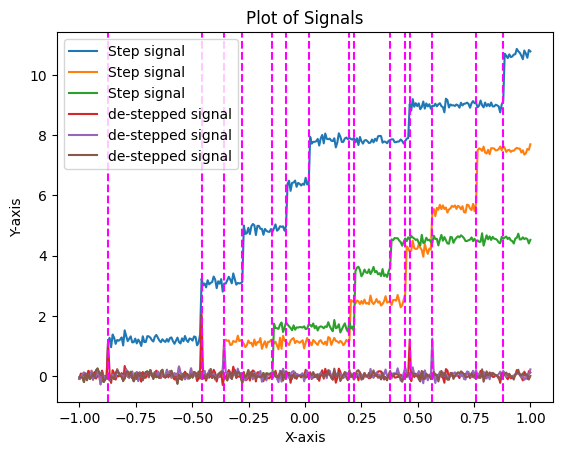

In [ ]:
x_step_removed, stepList = step_removal(x_step.T)
utils.plot_signals(t, [x_step.T, x_step_removed], y_names=["Step signal", "de-stepped signal"], y_lines=[t[step] for step in stepList])

## 6. Ringing removal

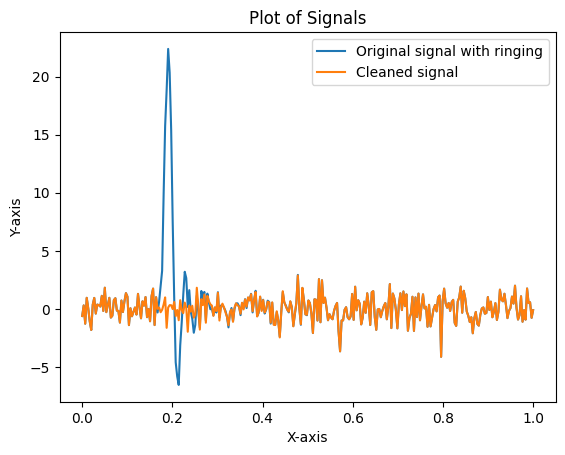

In [ ]:
def ringing_removal(x, step_list):
    """
    Reduce ringing effect caused by the antialiasing filter response to steps

    Paramters:
    - x: (Nsamples, Nchannels) data matrix
    - step_list: list of step indexes (can be found with step removal algorithm)

    Return:
    - new_x: cleaned data
    """
    N = x.shape[1]
    n_num, n_den = 8, 8
    n_samples = 100

    new_x = x.copy()
    for step in step_list:
        for n in range(N):
            ringing = x[step : step+n_samples, n]
            ringing = np.concatenate([ringing, np.zeros_like(ringing)])
            b, a = stmcb(ringing, q=n_num, p=n_den, niter=10)

            impulse = np.arange(n_samples) == 0
            model = lfilter(b, a, impulse)
            new_x[step : step+n_samples, n] -= model

    return new_x


[b, a] = butter(6, 0.2)
x = np.arange(300) == 0
x = lfilter(b, a, x) * 100
x = np.roll(x, 50) + np.random.normal(size=300)
x = x[:, None]
t = np.linspace(0, 1, x.shape[0])

new_x = ringing_removal(x, [50])
utils.plot_signals(t, [x, new_x], y_names=["Original signal with ringing", "Cleaned signal"])

[1] Alain de Cheveigné, Dorothée Arzounian,
Robust detrending, rereferencing, outlier detection, and inpainting for multichannel data,
NeuroImage,
Volume 172,
2018,
Pages 903-912,
ISSN 1053-8119,
https://doi.org/10.1016/j.neuroimage.2018.01.035.
(https://www.sciencedirect.com/science/article/pii/S1053811918300351)
Abstract: Electroencephalography (EEG), magnetoencephalography (MEG) and related techniques are prone to glitches, slow drift, steps, etc., that contaminate the data and interfere with the analysis and interpretation. These artifacts are usually addressed in a preprocessing phase that attempts to remove them or minimize their impact. This paper offers a set of useful techniques for this purpose: robust detrending, robust rereferencing, outlier detection, data interpolation (inpainting), step removal, and filter ringing artifact removal. These techniques provide a less wasteful alternative to discarding corrupted trials or channels, and they are relatively immune to artifacts that disrupt alternative approaches such as filtering. Robust detrending allows slow drifts and common mode signals to be factored out while avoiding the deleterious effects of glitches. Robust rereferencing reduces the impact of artifacts on the reference. Inpainting allows corrupt data to be interpolated from intact parts based on the correlation structure estimated over the intact parts. Outlier detection allows the corrupt parts to be identified. Step removal fixes the high-amplitude flux jump artifacts that are common with some MEG systems. Ringing removal allows the ringing response of the antialiasing filter to glitches (steps, pulses) to be suppressed. The performance of the methods is illustrated and evaluated using synthetic data and data from real EEG and MEG systems. These methods, which are mainly automatic and require little tuning, can greatly improve the quality of the data.
Keywords: EEG; MEG; LFP; ECoG; Artifact; ICA; CSP; DSS; SNS; CCA; Sensor noise; Detrending; Weighted regression; Robust statistics
